In [1]:
# !pip download tabpfn[full] -d ./tabpfn/
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/tabpfn-full/
# !pip install -q /kaggle/input/tabpfn-full/tabpfn-0.1.9-py3-none-any.whl # この書き方はだめ
!pip install tabpfn --no-index --find-links=file:///kaggle/input/tabpfn-full/


pyenv: version `3.10.11' is not installed (set by /home/eringi/kaggle/.python-version)


In [2]:
# ! ls ../input/tabpfn
# ! ls /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

In [3]:
# !mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/tabpfn/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
# from pytorch_tabnet.tab_model import TabNetClassifier
# from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from tabpfn import TabPFNClassifier

print('python:', sys.version)
print('torch:', torch.__version__)
# print(torch.cuda.get_device_name(),'is available? ->', torch.cuda.is_available())
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
BATCHSIZE = 8
EPOCHS = 50


/home/eringi/kaggle/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


python: 3.10.11 (main, May  7 2023, 19:24:25) [Clang 16.0.3 ]
torch: 1.13.1+cu117


In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.info

In [6]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


0      22.5984
1      19.4205
2      26.4825
3      23.6577
4      24.0108
        ...   
612    21.1860
613    27.1887
614    20.4798
615    19.0674
616    21.1860
Name: BN, Length: 617, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5ba1931b40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5ba1932080>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5ba19318a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5ba19325c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5ba1932860>],
 'means': []}

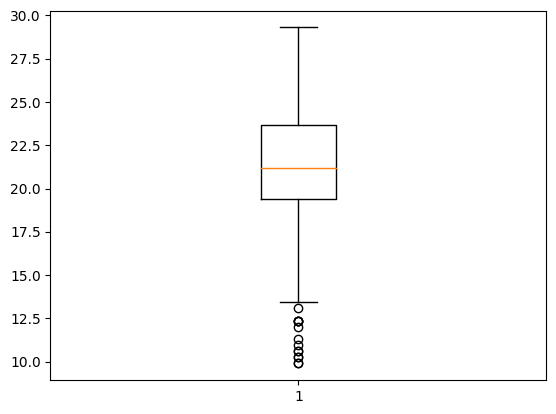

In [7]:
BN = train['BN']
print(BN)
plt.boxplot(BN)

In [8]:
train.Class.value_counts()

Class
0    509
1    108
Name: count, dtype: int64

* 学習データは617件
* EJだけ数値ではない


<Axes: >

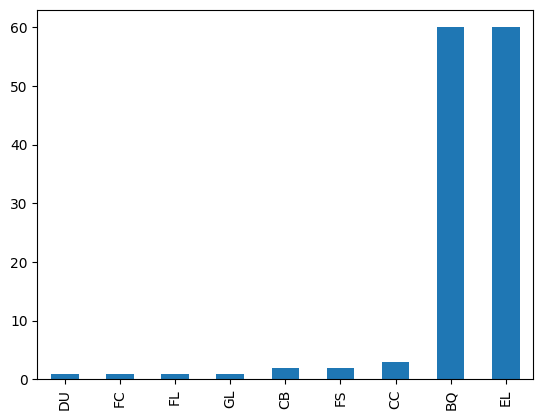

In [9]:
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [10]:
missing

DU     1
FC     1
FL     1
GL     1
CB     2
FS     2
CC     3
BQ    60
EL    60
dtype: int64

In [11]:
#欠損値処理
#欠損があるのは数値データのみ
#ひとまず中央値で埋めてみる
for k, v in missing.items():
    train[k] = train[k].fillna(train[k].mean())

In [12]:
#EJ列のカテゴリ数
EJ_categories = train['EJ'].unique()
EJ_categories
# output: array(['B', 'A'], dtype=object)

array(['B', 'A'], dtype=object)

In [13]:
# EJ列を2値化
LE = LabelEncoder()
train['labeled_EJ'] = LE.fit_transform(train['EJ'].values)
test['labeled_EJ'] = LE.fit_transform(test['EJ'].values)
train['labeled_EJ']

0      1
1      0
2      1
3      1
4      1
      ..
612    0
613    1
614    0
615    1
616    0
Name: labeled_EJ, Length: 617, dtype: int64

In [14]:
# train_class1 = train[train['Class']==1]
# train_class0 = train[train['Class']==0]

# train_class0 = train_class0.sample(n=len(train_class1)*2, random_state=5)
# train = pd.concat([train_class0, train_class1])
# train


* class1の数をclass0に合わせると過学習
* データは全部使う方針で

In [15]:
#外れ値を調べる
#全部グラフ化するのめんどいので四分位数だけ調べる

cols = train.columns
cols = cols.drop(['Id', 'EJ', 'Class'])

train_quantitative = train[cols]
test_x = test[cols]

first_quartiles = train_quantitative.quantile(0.25)
third_quartiles = train_quantitative.quantile(0.75)

iqr = third_quartiles - first_quartiles

lower_bound = first_quartiles - (iqr * 1.5) #外れ値の下限
upper_bound = third_quartiles + (iqr * 1.5) #外れ値の上限

# train[cols] = train[(train[cols] > lower_bound) | (train[cols] < upper_bound)]
train_quantitative = train_quantitative.clip(lower_bound, upper_bound, axis=1)

<Axes: >

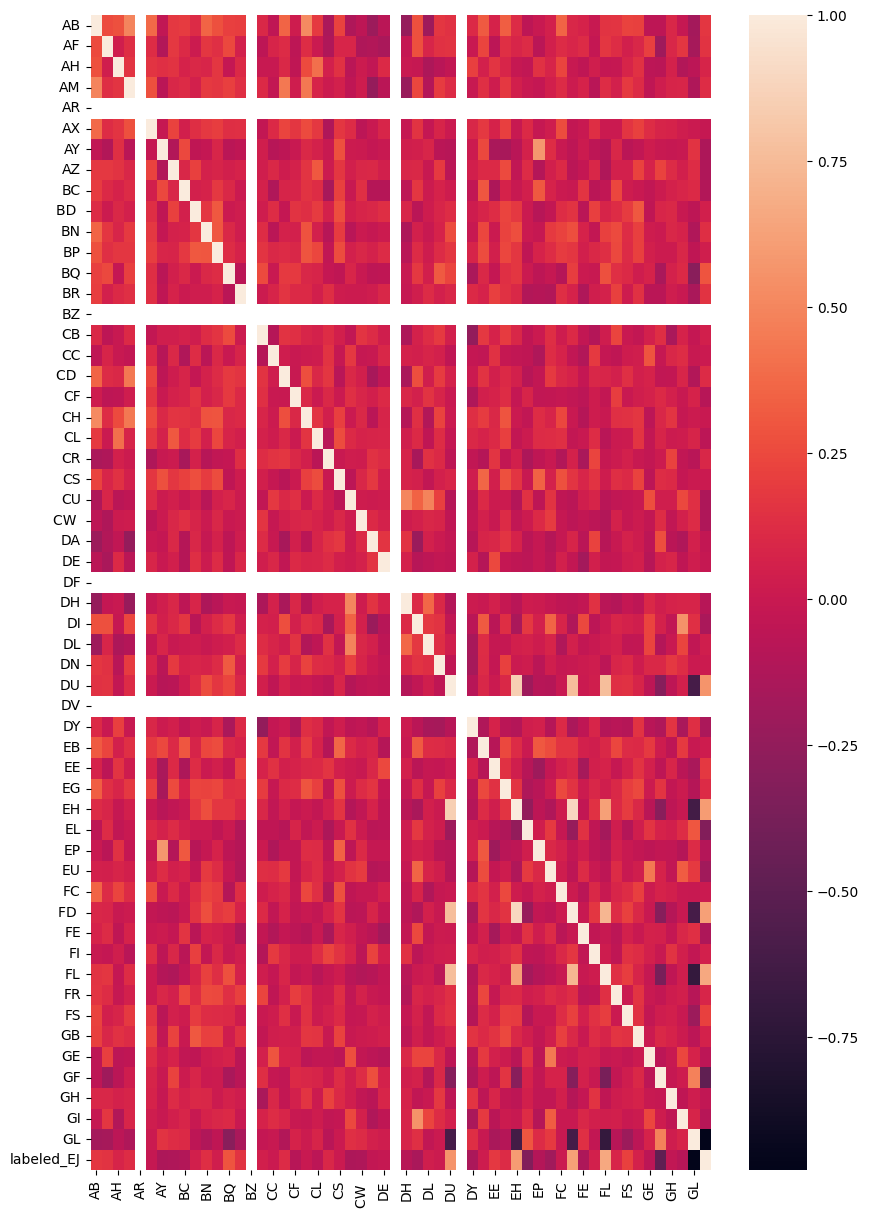

In [16]:
plt.figure(1, figsize=(10,15))
corr = train_quantitative.corr()
sns.heatmap(corr)
#quantitativeとqualitativeの列の相関
# plt.figure(2, figsize=(10,15))
# plt.figure(3, figsize=(10,15))
# corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
# for q1 in quantitative+['SalePrice']:
#     for q2 in qual_encoded+['SalePrice']:
#         corr.loc[q1, q2] = train[q1].corr(train[q2])
# sns.heatmap(corr)

In [17]:
# データ分割
x = train_quantitative
y = train['Class']
train_val_x, test_x, train_val_y, test_y = train_test_split(train_quantitative, y, train_size=0.8, shuffle=True, random_state=20)
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, train_size=0.8, shuffle=True, random_state=20)

In [18]:
# 学習

class BLloss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, preds, y):
        softmax_preds = nn.Softmax(dim=-1)(preds)
        N_0 = N_1 = 0
        y_0 = y_1 = [0]*BATCHSIZE

        for i, p in enumerate(softmax_preds):
            if p[0] > p[1]:
                N_0 += 1
            else:
                N_1 += 1
        for i, cls in enumerate(y):
            if cls == 0: y_0[i] = 1
            else: y_1[i] = 1

        loss_0 = loss_1 = 0
        total_loss = 0

        if N_0 == 0:
            total_loss =  1/N_1 * (torch.tensor(y_1).to(device=device) * torch.log(softmax_preds[:, 1]))
        elif N_1 == 0:
            total_loss = 1/N_0 * (torch.tensor(y_0).to(device=device) * torch.log(softmax_preds[:, 0]))
        else:
            loss_0 = 1/N_0 * (torch.tensor(y_0).to(device=device) * torch.log(softmax_preds[:, 0]))
            loss_1 = 1/N_1 * (torch.tensor(y_1).to(device=device) * torch.log(softmax_preds[:, 1]))

            total_loss = loss_0 + loss_1

        return -total_loss.sum()/2

# clf = TabNetClassifier(
#     optimizer_fn=torch.optim.Adadelta,
#     optimizer_params=dict(lr=1e-4),
#     scheduler_params={
#         'step_size': 20,
#         'gamma': 0.8
#     },
#     scheduler_fn=torch.optim.lr_scheduler.StepLR,
# )

tabpfn_clf = TabPFNClassifier(
    device=device,
    N_ensemble_configurations=32
)

criterion = BLloss()
# clf.fit(
#     X_train=train_x.to_numpy(), y_train=train_y.to_numpy(),
#     eval_set=[(val_x.to_numpy(), val_y.to_numpy())],
#     eval_metric=['logloss'],
#     batch_size=BATCHSIZE,
#     max_epochs=EPOCHS,
#     loss_fn=criterion
# )

tabpfn_clf.fit(train_val_x.to_numpy(), train_val_y.to_numpy())

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=32)

In [19]:
# 全部0を出すという論外な結果に
# 出してないけどたぶんrecallはほぼ0
# preds = clf.predict(test_x.to_numpy())
# tabpfn_preds, tabpfn_probs = tabpfn_clf.predict(test_x.to_numpy(), return_winning_probability=True)
proba = tabpfn_clf.predict_proba(test_x.to_numpy())
print(proba)
correct_cnt = 0
# for pred, ans in zip(tabpfn_preds, test_y):
#     # print(pred, ans)
#     if pred == ans: correct_cnt += 1

# print("acculacy is ", correct_cnt / len(test_y))
# print(tabpfn_probs)

[[1.98386863e-01 8.01613152e-01]
 [9.88977730e-01 1.10222995e-02]
 [9.91901934e-01 8.09803791e-03]
 [9.80953932e-01 1.90460887e-02]
 [8.46098900e-01 1.53901085e-01]
 [9.99843121e-01 1.56798778e-04]
 [9.99454916e-01 5.45073184e-04]
 [9.98373866e-01 1.62615185e-03]
 [9.42191839e-01 5.78081533e-02]
 [5.38268387e-02 9.46173191e-01]
 [9.98606503e-01 1.39353354e-03]
 [8.93419683e-01 1.06580295e-01]
 [9.30518627e-01 6.94813877e-02]
 [9.99693632e-01 3.06428265e-04]
 [1.63265452e-01 8.36734593e-01]
 [1.45022050e-01 8.54977965e-01]
 [9.79577243e-01 2.04226952e-02]
 [9.98792529e-01 1.20745425e-03]
 [9.95309651e-01 4.69034491e-03]
 [9.76926386e-01 2.30736211e-02]
 [9.99900460e-01 9.95760856e-05]
 [9.78931069e-01 2.10689828e-02]
 [9.99633312e-01 3.66618711e-04]
 [9.97168958e-01 2.83099199e-03]
 [9.91469562e-01 8.53041001e-03]
 [8.15835953e-01 1.84164003e-01]
 [9.99348104e-01 6.51917187e-04]
 [9.86494541e-01 1.35054793e-02]
 [6.80404436e-03 9.93196011e-01]
 [9.90407765e-01 9.59220435e-03]
 [9.831787

In [20]:
# ここからtest.csvの加工

test_quantitative = test[cols]

first_quartiles = test_quantitative.quantile(0.25)
third_quartiles = test_quantitative.quantile(0.75)

iqr = third_quartiles - first_quartiles

lower_bound = first_quartiles - (iqr * 1.5) #外れ値の下限
upper_bound = third_quartiles + (iqr * 1.5) #外れ値の上限

# train[cols] = train[(train[cols] > lower_bound) | (train[cols] < upper_bound)]
test_quantitative = test_quantitative.clip(lower_bound, upper_bound, axis=1)

test_proba = tabpfn_clf.predict_proba(test_quantitative.to_numpy())

In [21]:
# probs = clf.predict_proba(test_x.to_numpy())
submit_df = pd.DataFrame(columns=['Id', 'class_0', 'class_1'])
submit_df['Id'] = test['Id']
submit_df['class_0'] = test_proba[:, 0]
submit_df['class_1'] = test_proba[:, 1]
submit_df.to_csv('submission.csv', index=False)